In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Concatenate

In [2]:
np.random.seed(123)

In [82]:
# Params
n_stores = 3
n_days = 365
store_ids = [f"Store_{i}" for i in range(n_stores)]
time_depth = 21
split_date = pd.to_datetime("2022-10-01")
horizon = 7
store_embedding_size = 4

In [4]:
data = []

for store in store_ids:
    base_sales = np.random.randint(80,120)
    seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi, n_days))
    promo = np.random.binomial(1, 0.2, n_days)
    temp = 15 + 10 * np.sin(np.linspace(0,4 * np.pi, n_days)) + np.random.normal(0,2,n_days)
    noise = np.random.normal(0,5,n_days)
    sales = base_sales + seasonality + 5 * promo - 0.5 * temp + noise

    df_store = pd.DataFrame({
            "Date": pd.date_range("2022-01-01", periods=n_days),
            "Store_ID": store,
            "Sales" : sales,
            "Promo": promo,
            "Temperature": temp
    })

    data.append(df_store)

df = pd.concat(data).reset_index(drop=True)

In [5]:
df.sort_values(["Date","Store_ID"]).head()

Date Store_ID       Sales  Promo  Temperature
0   2022-01-01  Store_0   76.655651      0    16.044601
365 2022-01-01  Store_1  102.055465      1    13.943660
730 2022-01-01  Store_2   91.410729      0    13.189264
1   2022-01-02  Store_0   76.532664      0    11.331789
366 2022-01-02  Store_1   92.181945      1     9.456350

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Store_ID_encoded"] = le.fit_transform(df["Store_ID"])

df_train = df[df["Date"] < split_date].copy()
df_val = df[df["Date"] >= split_date].copy()

In [56]:
df.sort_values(["Store_ID","Date"]).head(30)

Date Store_ID      Sales  Promo  Temperature  Store_ID_encoded
0  2022-01-01  Store_0  76.655651      0    16.044601                 0
1  2022-01-02  Store_0  76.532664      0    11.331789                 0
2  2022-01-03  Store_0  77.475796      0    16.794821                 0
3  2022-01-04  Store_0  80.720992      0    16.553905                 0
4  2022-01-05  Store_0  74.302497      1    13.453833                 0
5  2022-01-06  Store_0  70.005424      0    17.600077                 0
6  2022-01-07  Store_0  69.933949      0    18.686621                 0
7  2022-01-08  Store_0  82.066055      0    18.840843                 0
8  2022-01-09  Store_0  73.751797      0    18.783032                 0
9  2022-01-10  Store_0  87.511423      0    17.070255                 0
10 2022-01-11  Store_0  69.310008      0    21.388124                 0
11 2022-01-12  Store_0  76.307953      0    18.330399                 0
12 2022-01-13  Store_0  75.562110      0    17.545049                 0
13 2022-01-14  Store_0  69.911688      0    17.017780                 0
14 2022-01-15  Store_0  78.195035      0    19.910290                 0
15 2022-01-16  Store_0  63.035595      0    20.706345                 0
16 2022-01-17  Store_0  69.212754      0    21.703402                 0
17 2022-01-18  Store_0  76.324532      0    22.647419                 0
18 2022-01-19  Store_0  77.802765      0    20.537218                 0
19 2022-01-20  Store_0  93.299570      1    18.227577                 0
20 2022-01-21  Store_0  77.595402      0    22.522319                 0
21 2022-01-22  Store_0  82.312468      0    23.667156                 0
22 2022-01-23  Store_0  68.832468      0    22.825725                 0
23 2022-01-24  Store_0  76.851951      0    21.807714                 0
24 2022-01-25  Store_0  80.634688      0    18.847211                 0
25 2022-01-26  Store_0  80.800652      0    22.463435                 0
26 2022-01-27  Store_0  82.655849      0    20.422077                 0
27 2022-01-28  Store_0  71.474832      0    21.872956                 0
28 2022-01-29  Store_0  77.601891      0    20.411466                 0
29 2022-01-30  Store_0  72.629396      0    22.633365                 0

In [83]:
def create_sequences(df, time_steps=14, time_horizon=1):
    """
    G√©n√®re des s√©quences temporelles √† partir d‚Äôun DataFrame pour l'entra√Ænement d‚Äôun mod√®le s√©quentiel.

    Cette fonction extrait, pour chaque magasin, des s√©quences glissantes de caract√©ristiques sur une fen√™tre
    de `time_steps` jours, et associe √† chaque s√©quence une valeur cible correspondant aux ventes √† pr√©dire
    √† un horizon temporel donn√© (`time_horizon`). Elle encode √©galement l'identifiant du magasin pour chaque s√©quence.

    Param√®tres :
    ----------
    df : pandas.DataFrame
        DataFrame contenant les colonnes 'Store_ID', 'Store_ID_encoded', 'Date', 'Sales', 'Promo', 'Temperature'.
    time_steps : int, optionnel (par d√©faut = 14)
        Nombre de jours utilis√©s pour constituer chaque s√©quence d‚Äôentr√©e.
    time_horizon : int, optionnel (par d√©faut = 1)
        Horizon de pr√©diction : nombre de jours dans le futur pour lequel la pr√©diction est faite.
        Par exemple, `time_horizon=1` pr√©dit les ventes du jour suivant, `time_horizon=7` pr√©dit celles dans une semaine.

    Retours :
    -------
    sequences : np.ndarray
        Tableau de forme (n_samples, time_steps, n_features) contenant les s√©quences d‚Äôentr√©e.
    targets : np.ndarray
        Tableau de forme (n_samples,) contenant les valeurs de ventes √† pr√©dire √† l‚Äôhorizon sp√©cifi√©.
    store_ids : np.ndarray
        Tableau de forme (n_samples,) contenant l‚Äôidentifiant encod√© du magasin pour chaque s√©quence.
    """
    sequences = []
    targets = []
    store_ids = []
    th = time_horizon - 1
    
    for store_id in df["Store_ID"].unique():
        df_store = df[df["Store_ID"]==store_id].sort_values("Date")
        features = df_store[["Sales", "Promo", "Temperature"]].values
        store_encoded = df_store["Store_ID_encoded"].values[0]

        for i in range(len(features) - time_steps - th):
            seq = features[i:i+time_steps]
            target = features[i+time_steps+th][0] # Sales at t+time_horizon
            sequences.append(seq)
            targets.append(target)
            store_ids.append(store_encoded)
            
    return np.array(sequences), np.array(targets), np.array(store_ids)

X_train, y_train, store_ids_train = create_sequences(df_train,time_depth,horizon)
X_val, y_val, store_ids_val = create_sequences(df_val,time_depth,horizon)

In [85]:
y_train[0]

np.float64(71.47483194557068)

In [84]:
X_train[0]

array([[76.65565122,  0.        , 16.04460071],
       [76.53266427,  0.        , 11.33178881],
       [77.47579607,  0.        , 16.79482141],
       [80.72099172,  0.        , 16.55390466],
       [74.30249653,  1.        , 13.4538328 ],
       [70.00542429,  0.        , 17.60007717],
       [69.9339485 ,  0.        , 18.68662088],
       [82.06605465,  0.        , 18.8408434 ],
       [73.75179703,  0.        , 18.7830318 ],
       [87.5114233 ,  0.        , 17.07025513],
       [69.31000806,  0.        , 21.38812409],
       [76.30795309,  0.        , 18.33039855],
       [75.56211026,  0.        , 17.54504931],
       [69.91168811,  0.        , 17.01778003],
       [78.19503508,  0.        , 19.91028981],
       [63.03559513,  0.        , 20.70634451],
       [69.21275365,  0.        , 21.70340249],
       [76.32453249,  0.        , 22.64741892],
       [77.80276482,  0.        , 20.53721786],
       [93.29956973,  1.        , 18.22757728],
       [77.59540158,  0.        , 22.522

In [15]:
# # Entr√©es
# seq_input = Input(shape=(X_train.shape[1], X_train.shape[2])) # (21,3)
# store_input = Input(shape=(1,))

# # Embedding magasin
# store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input)
# store_embedding_flat = Flatten()(store_embedding)

# # LSTM
# x = LSTM(64)(seq_input)

# # Fusion
# x = Concatenate()([x, store_embedding_flat])
# output = Dense(1)(x)

# model = Model(inputs=[seq_input, store_input], outputs=output)
# model.compile(optimizer="adam", loss="mse")

In [86]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model

# Entr√©es
seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Array descriptifs(21, 3) des 21 pas 
                                                               # de temps pr√©c√©dents sur 3 variables
store_input = Input(shape=(1,)) # Entr√©e repr√©sentant l‚Äôidentifiant du magasin

# Embedding magasin
store_embedding = Embedding(input_dim=n_stores, output_dim=store_embedding_size)(store_input) # Transforme chaque identifiant de magasin en un vecteur dense de taille 4. 
                                                                           # Cela permet au mod√®le d‚Äôapprendre une repr√©sentation vectorielle de chaque magasin.
store_embedding_flat = Flatten()(store_embedding)

# Bloc LSTM enrichi
x = LSTM(128, return_sequences=True)(seq_input) # return_sequences=True : 
                                                # renvoie toute la s√©quence de sorties (une sortie par
                                                # pas de temps), et pas seulement la derni√®re.
x = BatchNormalization()(x) # Normalise les activations de la couche pr√©c√©dente pour chaque mini-lot.
x = Dropout(0.2)(x) # r√©gularisation qui consiste √† d√©sactiver al√©atoirement 20% des neurones

x = LSTM(64)(x) # deuxi√®me couche
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Fusion LSTM (comportement temporel) avec l'embedding magasin (comportement local)
x = Concatenate()([x, store_embedding_flat])

# Couche dense finale
output = Dense(1)(x)

# Mod√®le
model = Model(inputs=[seq_input, store_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [87]:
x

<KerasTensor shape=(None, 68), dtype=float32, sparse=False, ragged=False, name=keras_tensor_65>

In [88]:
output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_66>

In [89]:
model

<Functional name=functional_5, built=True>

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='loss',     # Surveille la perte sur le jeu de validation
    patience=20,            # Arr√™te l'entra√Ænement si aucune am√©lioration pendant 20 epochs
    restore_best_weights=True  # Restaure les poids du meilleur mod√®le
)

model.fit(
    [X_train, store_ids_train],
    y_train,
    epochs=250,
    batch_size=32,
    validation_data=([X_val, store_ids_val], y_val),
    callbacks=[early_stop]
)

Epoch 1/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 74ms/step - loss: 7498.1113 - mae: 86.1118 - val_loss: 6927.0469 - val_mae: 82.7615
Epoch 2/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 51ms/step - loss: 7399.9634 - mae: 85.6862 - val_loss: 6843.4448 - val_mae: 82.2642
Epoch 3/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 46ms/step - loss: 7331.9282 - mae: 85.3149 - val_loss: 6847.0513 - val_mae: 82.3004
Epoch 4/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 69ms/step - loss: 7231.5176 - mae: 84.7548 - val_loss: 6860.0107 - val_mae: 82.4008
Epoch 5/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 79ms/step - loss: 7128.3501 - mae: 84.1449 - val_loss: 6800.9819 - val_mae: 82.0636
Epoch 6/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 91ms/step - loss: 6999.3745 - mae: 83.3808 - val_loss: 6595.6064 - val_mae: 80.8285
Epo

In [46]:
# model.fit([X_train, store_ids_train], y_train, epochs=250, batch_size=32)

In [123]:
y_pred = model.predict([X_val, store_ids_val])

7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25ms/step


In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE : 4.39
RMSE : 31.61


In [125]:
y_val.shape

(195,)

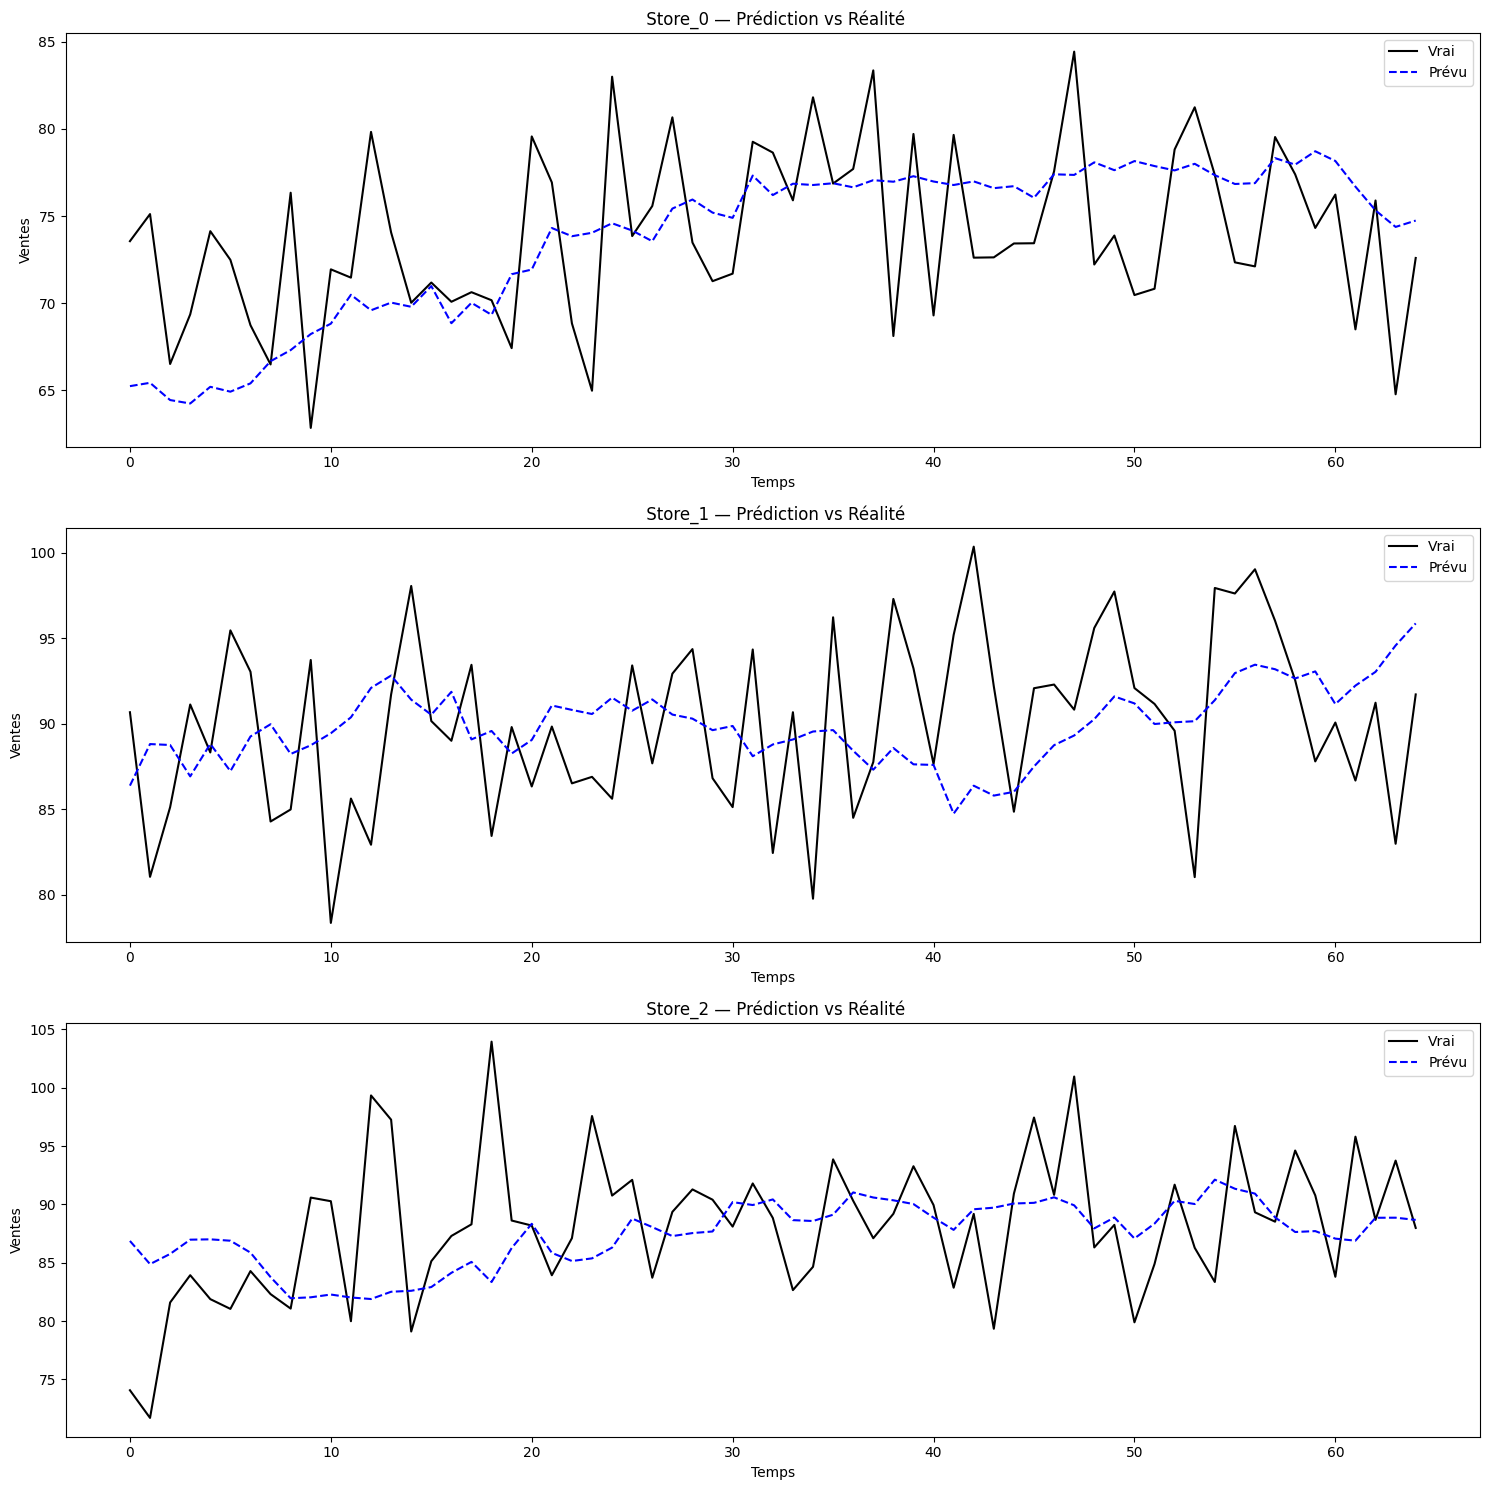

In [126]:
import matplotlib.pyplot as plt

# R√©cup√©rer les identifiants encod√©s
store_names = df["Store_ID"].unique()
store_encoded_map = dict(zip(le.transform(store_names), store_names))

# Tracer les courbes
plt.figure(figsize=(15, 5 * len(store_names)))

for i, store_code in enumerate(np.unique(store_ids_val)):
    # Filtrer les pr√©dictions et vraies valeurs pour ce magasin
    idx = store_ids_val == store_code
    y_true_store = y_val[idx]
    y_pred_store = y_pred[idx].flatten()
    
    # Tracer
    plt.subplot(len(store_names), 1, i + 1)
    plt.plot(y_true_store, label="Vrai", color="black")
    plt.plot(y_pred_store, label="Pr√©vu", color="blue", linestyle="--")
    plt.title(f" {store_encoded_map[store_code]} ‚Äî Pr√©diction vs R√©alit√©")
    plt.xlabel("Temps")
    plt.ylabel("Ventes")
    plt.legend()

plt.tight_layout()
plt.show()

# MLFLOW

In [111]:
import mlflow
import mlflow.keras
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import TensorSpec, Schema

In [121]:
# Indique √† MLflow o√π se trouve le serveur
mlflow.set_tracking_uri("http://localhost:5000")

# Optionnel : choisir un nom d‚Äôexp√©rience
mlflow.set_experiment("Pr√©vision des ventes")

embedding_dim = 5

with mlflow.start_run():
    # Enregistre les param√®tres du mod√®le
    mlflow.log_param("time_depth", 21)
    mlflow.log_param("forecast_horizon", 7)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("architecture", "LSTM + Embedding")

    # Log des hyperparam√®tres
    mlflow.log_param("first_layer_size", 128)
    mlflow.log_param("first_layer_dropout", 0.2)
    mlflow.log_param("second_layer_size", 64)
    mlflow.log_param("second_layer_dropout", 0.2)
    mlflow.log_param("embedding_dim", embedding_dim)

    mlflow.log_param("epochs", 250)
    mlflow.log_param("batch_size", 32)
    
    # D√©finition du mod√®le
    seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
    store_input = Input(shape=(1,))
    store_embedding = Embedding(input_dim=n_stores, output_dim=embedding_dim)(store_input)
    store_embedding_flat = Flatten()(store_embedding)

    x = LSTM(128, return_sequences=True)(seq_input)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(64)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Concatenate()([x, store_embedding_flat])
    output = Dense(1)(x)

    model = Model(inputs=[seq_input, store_input], outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    # Early stop
    early_stop = EarlyStopping(
    monitor='val_loss',     # Surveille la perte sur le jeu de validation
    patience=20,            # Arr√™te l'entra√Ænement si aucune am√©lioration pendant 20 epochs
    restore_best_weights=True  # Restaure les poids du meilleur mod√®le
    )
    # Entra√Ænement
    history = model.fit(
        [X_train, store_ids_train],
        y_train,
        validation_data=([X_val, store_ids_val], y_val),
        epochs=250,
        batch_size=32,
        callbacks=[early_stop]
    )


    # Log des m√©triques finales
    mlflow.log_metric("val_loss", history.history["val_loss"][-21])
    mlflow.log_metric("val_mae", history.history["val_mae"][-21])

    mlflow.log_metric("train_mae", history.history["mae"][-21])
    mlflow.log_metric("train_loss", history.history["loss"][-21])

    # D√©finition de la signature
    signature = ModelSignature(
    inputs=Schema([
        TensorSpec(np.dtype("float32"), (-1, X_train.shape[1], X_train.shape[2]), name="sequence_input"),
        TensorSpec(np.dtype("int32"), (-1, 1), name="store_input")
    ]),
    outputs=Schema([
        TensorSpec(np.dtype("float32"), (-1, 1))
    ])
    )
    
    # Sauvegarde du mod√®le Keras
    mlflow.keras.log_model(model, name="model_essai", signature=signature)


Epoch 1/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 31ms/step - loss: 7522.3950 - mae: 86.0853 - val_loss: 6964.0742 - val_mae: 82.9812
Epoch 2/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - loss: 7416.6089 - mae: 85.7127 - val_loss: 6853.1147 - val_mae: 82.3257
Epoch 3/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - loss: 7347.7588 - mae: 85.3501 - val_loss: 6796.6919 - val_mae: 82.0004
Epoch 4/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - loss: 7241.3975 - mae: 84.8083 - val_loss: 6847.1655 - val_mae: 82.3141
Epoch 5/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - loss: 7137.5068 - mae: 84.1952 - val_loss: 6679.0449 - val_mae: 81.3152
Epoch 6/250
24/24 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - loss: 7021.2729 - mae: 83.4994 - val_loss: 6774.7334 - val_mae: 81.8892
Epoc

In [122]:
print(np.array([[store_ids_train[0]]]))

[[0]]


In [120]:
type(input_example["sequence_input"])

list